In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

sns.set(style="ticks", context="talk", rc={'figure.figsize':(20,10), 'figure.dpi':300})
plt.style.use("dark_background")

In [305]:
def extract_features(path, cols, label, window_size=100, padding=0):
    features = ['mean', 'std', 'median', 'max', 'min', 'max_min_diff', 'neg_values', 'pos_values', 
                'kurtosis', 'skewness', 'median_abs_dev', 'iqr', 'energy']
    
    columns = []
    for f in features:
        for c in cols:
            columns.append(f+'_'+c)
            
    n_cols = len(cols)
    data = {'file':[], 'fall':[], 'n_window': []}
    for c in columns:
        data[c] = []  
    
    for file in os.listdir(path):
        df = pd.read_csv(path+file)
        df = df.dropna()
        windows = int(df.shape[0]/window_size)
        for i in range(padding, windows-padding):
            row = []
            for c in cols:
                row.append(df.iloc[i*window_size:(i+1)*window_size][c])
            
            data['file'].append(path+file)
            data['fall'].append(label)
            data['n_window'].append(i)
            
            for j in range(n_cols):
                #mean
                data['mean_'+cols[j]].append(row[j].mean())
                #std
                data['std_'+cols[j]].append(row[j].std())
                #median
                data['median_'+cols[j]].append(row[j].median())
                #min
                data['min_'+cols[j]].append(row[j].min())
                #max
                data['max_'+cols[j]].append(row[j].max())
                #max_min_diff
                data['max_min_diff_'+cols[j]].append(row[j].max() - row[j].min())
                #neg_values
                data['neg_values_'+cols[j]].append(row[j][row[j] < 0].count())
                #pos_values
                data['pos_values_'+cols[j]].append(row[j][row[j] >= 0].count())
                #kurtosis
                data['kurtosis_'+cols[j]].append(row[j].kurtosis())
                #skewness
                data['skewness_'+cols[j]].append(row[j].skew())
                #median_abs_dev
                data['median_abs_dev_'+cols[j]].append(np.median(abs(row[j] - np.median(row[j]))))
                #iqr
                data['iqr_'+cols[j]].append(np.percentile(row[j], 75) - np.percentile(row[j], 25))
                #energy
                data['energy_'+cols[j]].append(np.sum(row[j]**2)/100)
                
    return pd.DataFrame(data)

In [306]:
def fit(X, Y, n_splits=10, test_size=0.2, max_features=-1, n_neighbors=5):
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, Y)
    if max_features >= 1:
        model = SelectFromModel(lsvc, prefit=True, max_features=max_features)
    else:
        model = SelectFromModel(lsvc, prefit=True)
    
    X_lsvc = model.transform(X)
    
    clf = ExtraTreesClassifier(n_estimators=100)
    clf = clf.fit(X, Y)
    if max_features >= 1:
        model = SelectFromModel(clf, prefit=True, max_features=max_features)
    else:
        model = SelectFromModel(clf, prefit=True)
    X_clf = model.transform(X)
    
    Xs = [X, X_lsvc, X_clf]
    features = ['All features', 'LSVC features', 'Tree features']
    models = [KNeighborsClassifier(n_neighbors=n_neighbors), 
              RandomForestClassifier(n_estimators=100, n_jobs=4), GaussianNB(), 
              DecisionTreeClassifier()]
    models_str = ['KNN', 'Random Forest', 'Naive Bayes', 'Decision Tree']
    data = {'Model':[], 'Features': [], 'Score': []}
    
    i = 0
    j = 0
    for model in models:
        for feature in features:
            data['Model'].append(models_str[i])
            data['Features'].append(feature)
            data['Score'].append(np.mean(cross_val_score(model, Xs[j], Y, cv=cv)))
            j += 1
        i += 1
        j = 0
    
    return data

In [307]:
cols = ['ax', 'ay', 'az', 'wx', 'wy', 'wz']
window_size = 100
df = extract_features('data/Fall/', cols, 1, window_size, 0)
df2 = extract_features('data/No fall/', cols, 0, window_size, 0)
features_data = pd.concat([df, df2], axis=0)
features_data.shape
features_data.to_csv('data_w'+str(window_size)+'.csv', index=False)

In [308]:
data = pd.read_csv('data_w100.csv')
print(data.shape)
data.head()

(4828, 81)


,file,fall,n_window,mean_ax,mean_ay,mean_az,mean_wx,mean_wy,mean_wz,std_ax,...,iqr_az,iqr_wx,iqr_wy,iqr_wz,energy_ax,energy_ay,energy_az,energy_wx,energy_wy,energy_wz
0,data/Fall/001.csv,1,0,-0.2129,0.2513,0.0038,-0.4706,0.1372,-0.2036,0.168734,...,0.2825,0.1800,0.1900,0.0950,0.073513,0.098239,0.052494,0.229870,0.026988,0.044596
1,data/Fall/001.csv,1,1,0.2199,-0.0692,0.0982,-0.3045,0.0335,-0.0511,0.279767,...,0.3500,0.3025,0.3525,0.0800,0.125843,0.050926,0.060322,0.120623,0.028479,0.004957
2,data/Fall/001.csv,1,2,-0.2278,-0.3360,0.2181,-0.2809,-0.2619,-0.0126,0.412951,...,0.8200,0.1325,0.6000,0.1725,0.220716,0.165904,0.251385,0.093177,0.145359,0.008776
3,data/Fall/001.csv,1,3,0.1850,0.0266,-0.3605,-0.2270,-0.4739,-0.4733,0.606093,...,0.9000,0.1000,0.3325,0.5475,0.397900,0.244672,0.406395,0.058648,0.251979,0.325359
4,data/Fall/001.csv,1,4,-0.2277,0.0458,0.2058,-0.0659,-0.0855,0.2716,0.722154,...,0.5525,0.6625,0.3125,0.2500,0.568139,0.075628,0.276018,0.168425,0.097019,0.091916


In [312]:
X = data[data.columns[3:]]
Y = data['fall']
results = fit(X, Y)

In [313]:
res = pd.DataFrame(results)
res.head(12)

,Model,Features,Score
0,KNN,All features,0.604348
1,KNN,LSVC features,0.594099
2,KNN,Tree features,0.573292
3,Random Forest,All features,0.714079
4,Random Forest,LSVC features,0.702070
5,Random Forest,Tree features,0.716253
6,Naive Bayes,All features,0.568012
7,Naive Bayes,LSVC features,0.566667
8,Naive Bayes,Tree features,0.556418
9,Decision Tree,All features,0.630849


<AxesSubplot:xlabel='Features', ylabel='Score'>

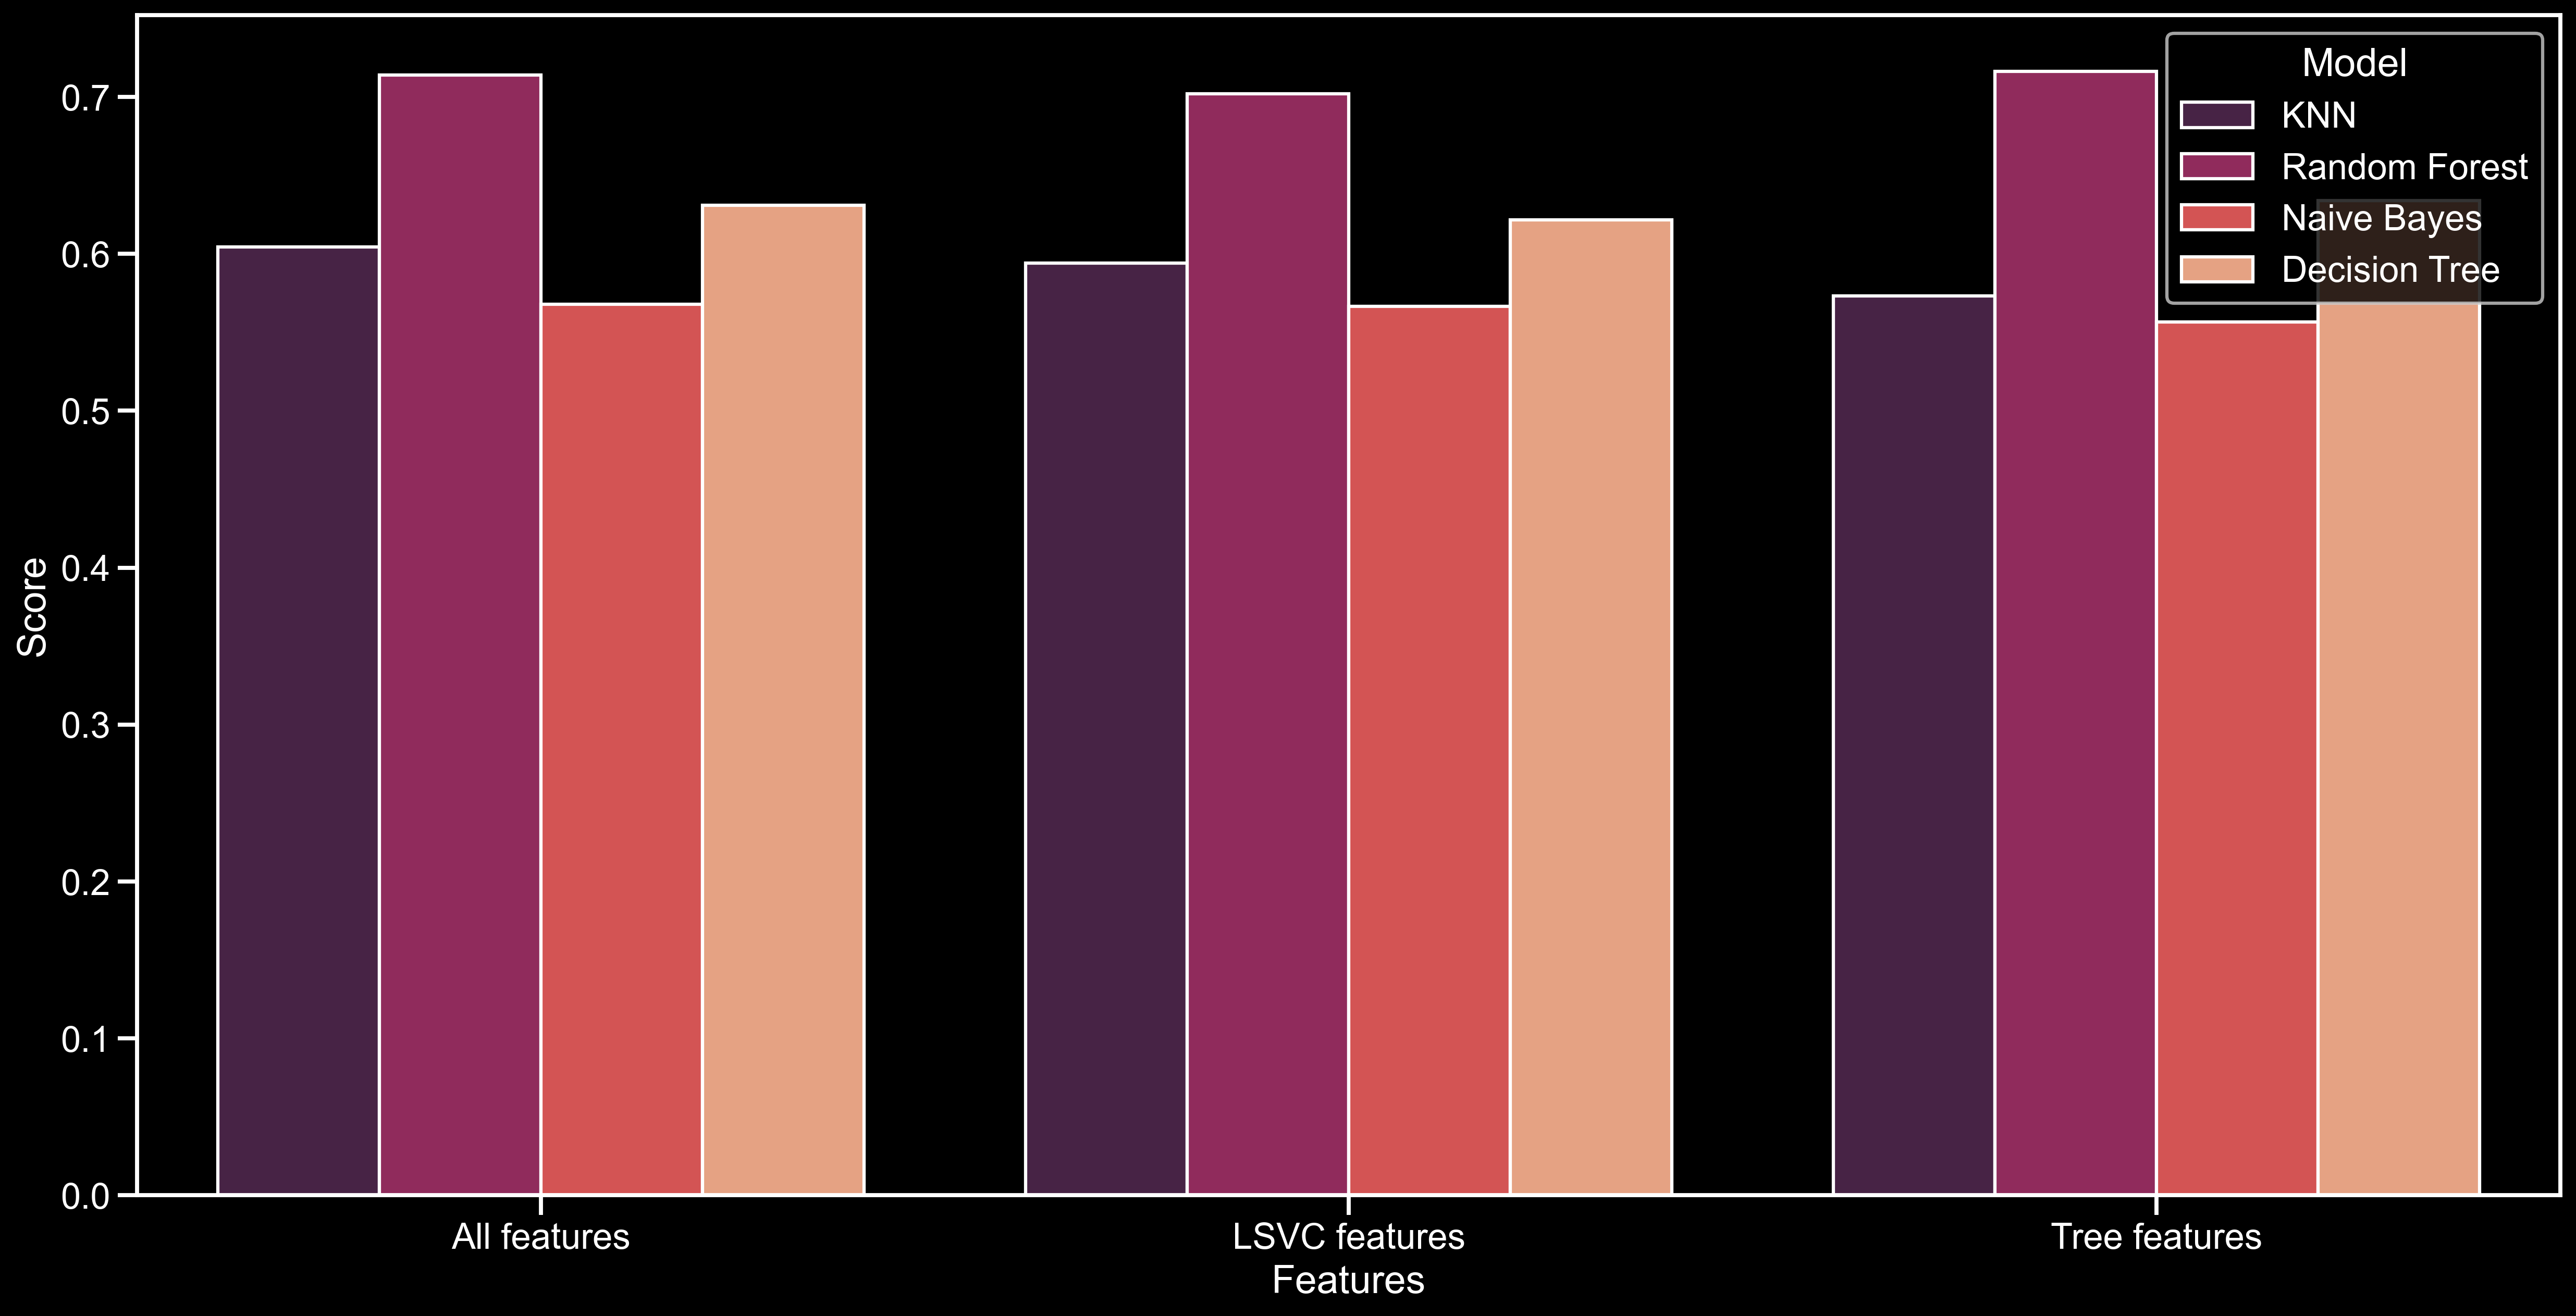

In [314]:
sns.barplot(data=res, x='Features', y='Score', hue='Model', palette='rocket')